Original paper: https://arxiv.org/abs/1311.2524?WT.mc_id=Blog_MachLearn_General_DI

**Modifications** : 

1. The original paper used AlexNet+SVM for the classification, in this case vgg19+fully connected layers were used (need more tuning).

2. There are some differences in implementing the NMS.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10

from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
import numpy as np
from keras.layers import Input, Dense, GlobalAveragePooling2D,Dropout,Reshape,BatchNormalization
import tensorflow as tf

import cv2

class RCNN_CIFAR10:
    def __init__(self,iou_thres=0.4,pred_thres=0.7,verbose=True):
        
        self.NCLASS = 10
        self.iou_thres = iou_thres
        self.pred_thres = pred_thres
        self.verbose=verbose
    
    def ohe(self, X, n_class):
        outputX = np.zeros((len(X),n_class))
        for i in range(len(X)):
            outputX[i,X[i]] = 1
        return outputX
    
    def load_label_names(self):
        return [*enumerate(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])]

    

    
    def img_slice(self, img:np.array,rect_coord:list):
        x, y, w, h = rect_coord
        sliced_img = img[y:y+h,x:x+w,:]
        return sliced_img
        
        
        
    def iou(self, coord_a,coord_b):




        # Coord
        x1a, y1a, w1a, h1a = coord_a
        x1b, y1b, w1b, h1b = coord_b

        x2a = x1a+w1a
        y2a = y1a+h1a

        x2b = x1b+w1b
        y2b = y1b+h1b


        # No intersection case:
        if (x2b<x1a and y2a< y1b) or (x1b<x2a and y2b< y1a):
            return 0



        intersection_x1 = max(x1a,x1b)
        intersection_y1 = max(y1a,y1b)
        intersection_x2 = min(x2a,x2b)
        intersection_y2 = min(y2a,y2b)

        intersection_area = float((intersection_y2 - intersection_y1) * (intersection_x2 - intersection_x1))

        union_area = w1a*h1a + w1b*h1b - intersection_area

    #     print('intersection:',intersection_area)
    #     print('union:',union_area)

        return intersection_area / union_area

    
    def train(
        self,
        batch_size = 256,
        epochs = 2,
        validation_split = 0.2
        
    ):
        
        # load data:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        
        y_train = self.ohe(y_train,self.NCLASS)
        y_test = self.ohe(y_test,self.NCLASS)
        
        self.x_test = x_test
        

        
        # Model:
        
        base_model = VGG19(input_shape=(32,32,3), weights='imagenet', include_top=False)
        # add a global spatial average pooling layer
        x = base_model.output

        # x = tf.einsum('ijkl->il', x)
        x = Reshape((512,))(x)
        x = BatchNormalization()(x)
        x = Dense(2048, activation='relu')(x)
        x = Dropout(rate=0.5)(x)
        output = Dense(10, activation='softmax')(x)
        model = Model(inputs=base_model.input, outputs=output)

        for layer in base_model.layers:
            layer.trainable = False
            
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
        model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs,  validation_split=validation_split)
        return model

        
    def evaluate(self, model, test_img):
        
        
        ###########
        # SS
        ###########
        cv2.setUseOptimized(True);
        cv2.setNumThreads(2);
        # create Selective Search Segmentation Object using default parameters
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        # set input image on which we will run segmentation
        ss.setBaseImage(test_img)
        ss.switchToSelectiveSearchQuality()
        self.rects  = ss.process()
        self.rects = self.rects[(self.rects[:,0]>0)&(self.rects[:,1]>0),:]
        
        ###########
        # Pred
        ###########
        
        
        all_preds = []

        for i in range(len(self.rects)):
            img_patch = self.img_slice(test_img,self.rects[0])
            img_patch = cv2.resize(img_patch,(32,32))
            img_patch = np.expand_dims(img_patch, axis=0)
            pred = model.predict(img_patch).tolist()[0]
            all_preds.append(pred)


        all_preds = np.array(all_preds)


        ###########
        # NMS
        ###########
        iou_res = np.zeros((len(self.rects),len(self.rects)))
        len_rects = len(self.rects)


        for i in range(len_rects):
            for j in range(len_rects):
                
                a = self.rects[i]
                b = self.rects[j]
                iou_res[i,j] = self.iou(a,b)


        iou_res[iou_res==1] = -1
        
        
        
        classes = self.load_label_names()

        drop_bbs = {}

        for cl in classes:
            class_drop_bbs = []

            temp_iou_res = iou_res.copy()
            while temp_iou_res.max() >= self.iou_thres and len(drop_bbs) < len(self.rects):

                max_val = temp_iou_res.max()
                
                if self.verbose:
                    print("current max IOU: {}".format(max_val))
                    print("current N drop bbox: {}".format(len(class_drop_bbs)))

                max_idxs = list(np.where(temp_iou_res==max_val))
                max_idxs[0] = max_idxs[0].tolist()
                max_idxs[1] = max_idxs[1].tolist()
                max_idxs = [*zip(max_idxs[0],max_idxs[1])]

                if self.verbose:
                    print("current max IOU idxs: {}".format(max_idxs))


                preds = all_preds[[i[0] for i in max_idxs],cl[0]]
                if self.verbose:
                    print("current max pred for the class: {}".format(preds.max()))
                # At least have certain confidence in class pred
                if preds.max() > self.pred_thres:
                    best_pred = preds.argmax()
                    max_idxs.pop(0)

                    bad_bboxs = [i[0] for i in max_idxs]
                    class_drop_bbs.extend(bad_bboxs)

                    temp_iou_res[bad_bboxs,:] = -1
                    temp_iou_res[:,bad_bboxs] = -1



                else:
                    if self.verbose:
                        print("----------class skipped----------".format(cl))
                    break

            if self.verbose:
                print("----------class {} DONE----------".format(cl))

            drop_bbs[cl[0]] = class_drop_bbs
            
            
        # Wrapup:
        pred_label = []
        imOut = test_img.copy()
        for cl in classes:
            bad_bbox = drop_bbs[cl[0]]
            if len(bad_bbox)>0:
                bad_bbox = list(set(bad_bbox))
                good_bbox_list = [i for i in range(len(self.rects)) if i not in bad_bbox]
                if  len(good_bbox_list) > 0:
                    pred_label.append(cl[1])

                        # itereate over all the region proposals
                for i in good_bbox_list:
                    # draw rectangle for region proposal till numShowRects
                    x, y, w, h = self.rects[i]



                    cv2.rectangle(imOut, (x, y), (x+w, y+h), (255, 0, 0), 1)

        return imOut,pred_label

In [0]:
rcnn = RCNN_CIFAR10(iou_thres=0.25,pred_thres=0.5,verbose=False)

In [9]:
# 6418
model = rcnn.train(
        batch_size = 512,
        epochs = 20,
        validation_split = 0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 16s 350us/step - loss: 1.4014 - acc: 0.5287 - val_loss: 1.1670 - val_acc: 0.6058
Epoch 2/20
45000/45000 [==============================] - 15s 333us/step - loss: 1.1245 - acc: 0.6083 - val_loss: 1.1303 - val_acc: 0.6128
Epoch 3/20
45000/45000 [==============================] - 15s 333us/step - loss: 1.0307 - acc: 0.6414 - val_loss: 1.1026 - val_acc: 0.6254
Epoch 4/20
45000/45000 [==============================] - 15s 333us/step - loss: 0.9597 - acc: 0.6652 - val_loss: 1.0914 - val_acc: 0.6236
Epoch 5/20
45000/45000 [==============================] - 15s 333us/step - loss: 0.9070 - acc: 0.6811 - val_loss: 1.0883 - val_acc: 0.6266
Epoch 6/20
45000/45000 [==============================] - 15s 333us/step - loss: 0.8523 - acc: 0.7005 - val_loss: 1.0806 - val_acc: 0.6326
Epoch 7/20
45000/45000 [==============================] - 15s 334us/step - loss: 0.8017 - acc: 0.7182 - val_loss: 1.0

Predicted Label: 0,['airplane']


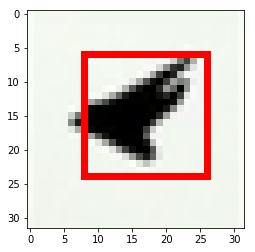

In [10]:
res = rcnn.evaluate(model,rcnn.x_test[21])
print("Predicted Label: {0},{1}".format(0,res[1]))
plt.imshow(res[0])

Predicted Label: 0,['truck']


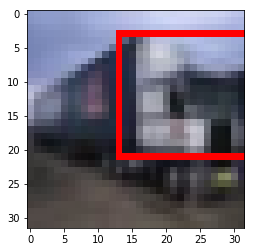

In [11]:
res = rcnn.evaluate(model,rcnn.x_test[34])
print("Predicted Label: {0},{1}".format(0,res[1]))
plt.imshow(res[0])

Predicted Label: 0,['airplane']


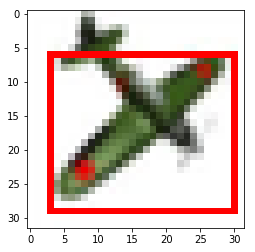

In [12]:
res = rcnn.evaluate(model,rcnn.x_test[98])
print("Predicted Label: {0},{1}".format(0,res[1]))
plt.imshow(res[0])

Predicted Label: 0,['cat']


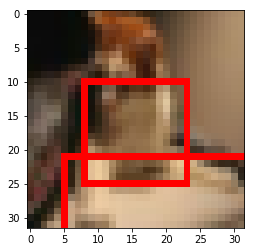

In [15]:
res = rcnn.evaluate(model,rcnn.x_test[61])
print("Predicted Label: {0},{1}".format(0,res[1]))
plt.imshow(res[0])

Predicted Label: 0,['cat']


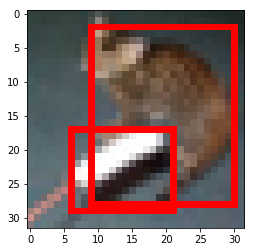

In [16]:
res = rcnn.evaluate(model,rcnn.x_test[106])
print("Predicted Label: {0},{1}".format(0,res[1]))
plt.imshow(res[0])

Predicted Label: 0,['airplane']


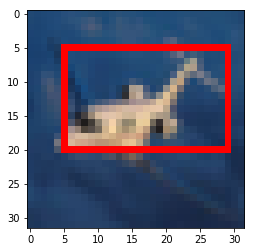

In [18]:
res = rcnn.evaluate(model,rcnn.x_test[206])
print("Predicted Label: {0},{1}".format(0,res[1]))
plt.imshow(res[0])

Predicted Label: 0,['airplane']


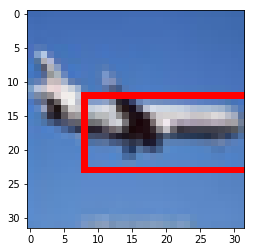

In [19]:
res = rcnn.evaluate(model,rcnn.x_test[235])
print("Predicted Label: {0},{1}".format(0,res[1]))
plt.imshow(res[0])

Predicted Label: 0,['deer']


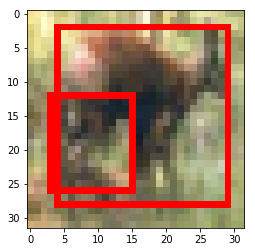

In [31]:
res = rcnn.evaluate(model,rcnn.x_test[278])
print("Predicted Label: {0},{1}".format(0,res[1]))
plt.imshow(res[0])

Predicted Label: 0,['bird']


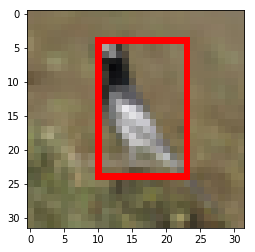

In [32]:
res = rcnn.evaluate(model,rcnn.x_test[291])
print("Predicted Label: {0},{1}".format(0,res[1]))
plt.imshow(res[0])

Predicted Label: 0,['ship']


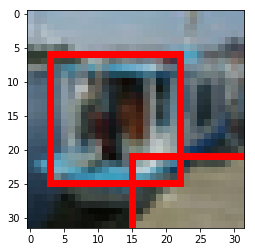

In [36]:
res = rcnn.evaluate(model,rcnn.x_test[306])
print("Predicted Label: {0},{1}".format(0,res[1]))
plt.imshow(res[0])

Predicted Label: 0,['bird']


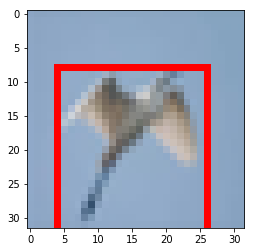

In [39]:
res = rcnn.evaluate(model,rcnn.x_test[342])
print("Predicted Label: {0},{1}".format(0,res[1]))
plt.imshow(res[0])

Predicted Label: 0,['automobile']


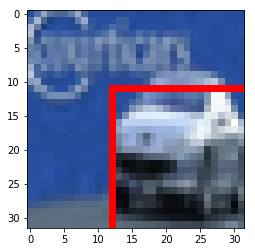

In [41]:
res = rcnn.evaluate(model,rcnn.x_test[363])
print("Predicted Label: {0},{1}".format(0,res[1]))
plt.imshow(res[0])

Predicted Label: 0,['bird']


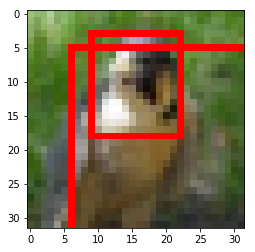

In [49]:
res = rcnn.evaluate(model,rcnn.x_test[384])
print("Predicted Label: {0},{1}".format(0,res[1]))
plt.imshow(res[0])

Predicted Label: 0,['dog']


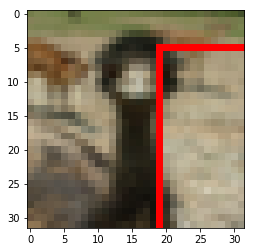

In [50]:
res = rcnn.evaluate(model,rcnn.x_test[396])
print("Predicted Label: {0},{1}".format(0,res[1]))
plt.imshow(res[0])

Predicted Label: 0,['dog']


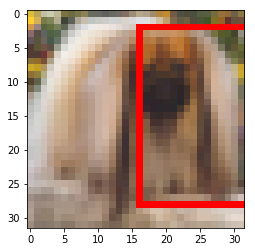

In [53]:
res = rcnn.evaluate(model,rcnn.x_test[389])
print("Predicted Label: {0},{1}".format(0,res[1]))
plt.imshow(res[0])

Predicted Label: 0,['truck']


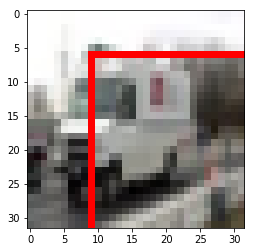

In [54]:
res = rcnn.evaluate(model,rcnn.x_test[372])
print("Predicted Label: {0},{1}".format(0,res[1]))
plt.imshow(res[0])